# yodapy examples Jupyter notebook

This notebook is designed to walk you through a number of different plots of data collected on the OOI Cabled Array during the time period of August 20-23, 2017 (this time period co-incides with the total solar eclipse that happened on August 21st.

## Inilization

To access the OOI API, credentials need to be set. In order to set this up, switch to the python environment that contains `yodapy` and then fire up python.
``` bash
$ python
```

Within the python console, set your credentials.

```python
from yodapy.utils.creds import set_credentials_file
set_credentials_file(data_source='ooi', username='Your OOI username', token='Your OOI token')
```

The initialization step places a special .yodapy/.credentials file in your home directory. Your ~/.yodapy/.credentials file should look something like this

```json
{"ooi": {"username": "Your OOI username", "api_key": "Your OOI token"}}
```

## Getting Started
First, we need to work on loading in some data from the OOI array. The visualoceanpy library is designed to make this easy via specification of an instrument identification string. These examples use one of the profiling shallow water buoys in the array.

In [1]:
from yodapy.datasources import OOI

/home/lsetiawan/miniconda/envs/yodapydev/lib/python3.6/site-packages/grequests.py:21: RuntimeWarning: Monkey-patching ssl after ssl has already been imported may lead to errors, including RecursionError on Python 3.6. Please monkey-patch earlier.
  curious_george.patch_all(thread=False, select=False)


In [2]:
ooi = OOI()

In [3]:
ooi.search(region='cabled', site='oregon slope base shallow profiler', instrument='CTD')

<Data Source: OOI>

In [4]:
ooi.view_instruments()

,reference_designator,name,start_depth,end_depth,current_status,preferred_stream,preferred_parameter,location
1218,RS01SBPS-PC01A-4A-CTDPFA103,CTD,200.0,200.0,,ctdpf_optode_sample,908,Mid-Water Platform
1222,RS01SBPS-SF01A-2A-CTDPFA102,CTD,5.0,200.0,,ctdpf_sbe43_sample,908,Shallow Profiler


In [5]:
# This example is designed to showcase basic data download
# over the time period of the 2017 solar eclipse

stdt = '2017-08-20'
enddt = '2017-08-23'

req_asset = ooi.request_data(
    begin_date=stdt,
    end_date=enddt
)

In [6]:
req_asset.raw()

[{'requestUUID': 'a123f429-ba23-4b57-b6ce-d50999226f78',
  'outputURL': 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/landungs@uw.edu/20180731T200312-RS01SBPS-PC01A-4A-CTDPFA103-streamed-ctdpf_optode_sample/catalog.html',
  'allURLs': ['https://opendap.oceanobservatories.org/thredds/catalog/ooi/landungs@uw.edu/20180731T200312-RS01SBPS-PC01A-4A-CTDPFA103-streamed-ctdpf_optode_sample/catalog.html',
   'https://opendap.oceanobservatories.org/async_results/landungs@uw.edu/20180731T200312-RS01SBPS-PC01A-4A-CTDPFA103-streamed-ctdpf_optode_sample'],
  'sizeCalculation': 16785860,
  'timeCalculation': 60,
  'numberOfSubJobs': 2},
 {'requestUUID': 'd369650a-8eee-4c12-a343-04819fb1d1ab',
  'outputURL': 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/landungs@uw.edu/20180731T200319-RS01SBPS-SF01A-2A-CTDPFA102-streamed-ctdpf_sbe43_sample/catalog.html',
  'allURLs': ['https://opendap.oceanobservatories.org/thredds/catalog/ooi/landungs@uw.edu/20180731T200319-RS01SBPS-SF01A-

In [7]:
# you need to wait for the request to complete
# after it completes, you can go to a URL to see whether your
# request is completed.

print(req_asset.raw()[0]['allURLs'][1])  # Go to url to see the status
print(req_asset.raw()[0]['allURLs'][0])  # Go to url to see status of thredds dataset

https://opendap.oceanobservatories.org/async_results/landungs@uw.edu/20180731T200312-RS01SBPS-PC01A-4A-CTDPFA103-streamed-ctdpf_optode_sample
https://opendap.oceanobservatories.org/thredds/catalog/ooi/landungs@uw.edu/20180731T200312-RS01SBPS-PC01A-4A-CTDPFA103-streamed-ctdpf_optode_sample/catalog.html


In [8]:
# now, need to convert from this structure to an pandas xarray
ds_list = ooi.to_xarray()

Request Completed


In [9]:
#TODO: Add in "offline" mode that allows for plotting 
#      without having to load data in via OOI every time
import xarray as xr
import matplotlib as mp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [10]:
from yodapy.utils.parser import seconds_to_date

In [11]:
# Plot a simple timeseries of temperature, and PSU vs. pressure
ds = ds_list[1]

In [12]:
# Vectorize seconds to date function for use in array data
s2d = np.vectorize(seconds_to_date)

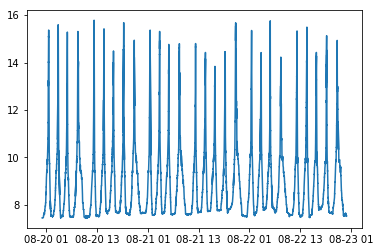

In [13]:
# pull out values from the xarray structure
pressure = ds['seawater_pressure'].data
temperature = ds['seawater_temperature'].data
psu = ds['practical_salinity'].data
ds_time = s2d(ds['time'].data)

# quick and dirty timeseries plot of temperature for sanity check
plt.plot(ds_time,temperature)
plt.show()

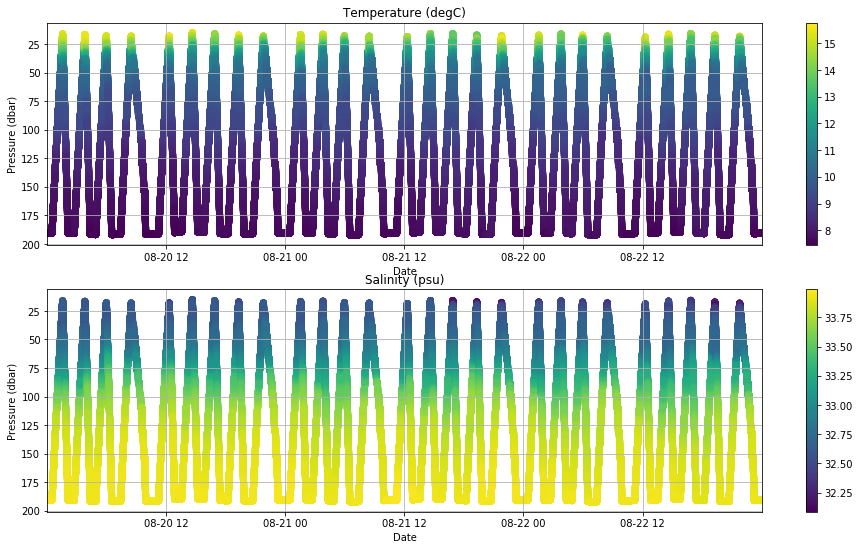

In [14]:
# Now, more complete colored scatter plot, with data plotted
# on a depth vs. time axis.

fig,(ax1,ax2) = plt.subplots(nrows=2,ncols=1)
fig.set_size_inches(16,9)

# plot temp and salinity curtain plots
ax1.invert_yaxis()
ax1.grid()
ax1.set_xlim(ds_time[0],ds_time[-1])
sc1 = ax1.scatter(ds_time,pressure,c=temperature)
ax1.set_xlabel('Date')
ax1.set_ylabel('Pressure (dbar)')
ax1.set_title('Temperature (degC)')
cb = fig.colorbar(sc1,ax=ax1)

ax2.invert_yaxis()
ax2.grid()
ax2.set_xlim(ds_time[0],ds_time[-1])
ax2.set_xlabel('Date')
ax2.set_ylabel('Pressure (dbar)')
ax2.set_title('Salinity (psu)')
sc2 = ax2.scatter(ds_time,pressure,c=psu)
cb2 = fig.colorbar(sc2,ax=ax2)
plt.show()

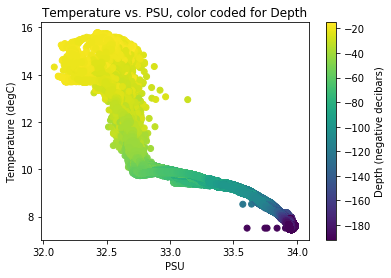

In [15]:
# Now, more complete colored scatter plot, with data plotted
# on a temperature vs. salinty axis, color coded for depth

fig2,(ax3) = plt.subplots(nrows=1,ncols=1)
fig2.set_size_inches(6,4)

sc3 = ax3.scatter(psu,temperature,c=(-1.0*pressure))
ax3.set_title('Temperature vs. PSU, color coded for Depth')
ax3.set_xlabel('PSU')
ax3.set_ylabel('Temperature (degC)')
cb = fig.colorbar(sc3,ax=ax3)
cb.set_label('Depth (negative decibars)')
plt.show()


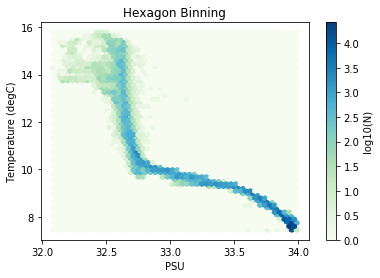

In [16]:
fig3,ax4 = plt.subplots(nrows=1,ncols=1)
fig3.set_size_inches(6,4)

hb = ax4.hexbin(psu,temperature,
                gridsize=50,
                bins='log',
                cmap=plt.cm.GnBu)
ax4.set_title('Hexagon Binning')
ax4.set_xlabel('PSU')
ax4.set_ylabel('Temperature (degC)')
cb = fig3.colorbar(hb, ax=ax4)
cb.set_label('log10(N)')
plt.show()


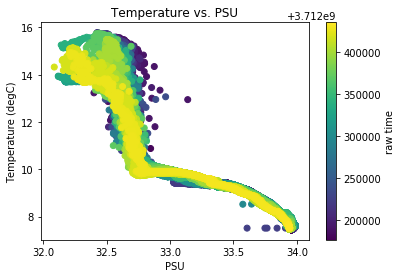

In [17]:
# Now, more complete colored scatter plot, with data plotted
# on a temperature vs. salinty axis, color coded for time (in seconds
# since )

fig2,(ax3) = plt.subplots(nrows=1,ncols=1)
fig2.set_size_inches(6,4)

sc3 = ax3.scatter(psu,temperature,c=(ds.time.data))
ax3.set_title('Temperature vs. PSU')
ax3.set_xlabel('PSU')
ax3.set_ylabel('Temperature (degC)')
cb = fig.colorbar(sc3,ax=ax3)
cb.set_label('raw time')
plt.show()


In [18]:
# This looks interesting, with distinct upper water masses in a couple
# different time periods. 
# TODO: Split into 4x4 plots to tease this out?